In [1]:
import os
import cv2
from pathlib import Path
import random
import torch
import glob
from shutil import copyfile

In [2]:
#Change disk directory
base_path = Path("G:/Dissertation/")
if(Path().cwd() != Path(r"G:\Dissertation")):
    os.chdir(base_path)

In [3]:
#Define data_paths
# raw_data_path = Path("raw_data/Data examples/")
# raw_visibility_path = raw_data_path / Path("1_Visibility/")
# raw_quality_path = raw_data_path/ Path("2_Quality/")
dataset_path = Path('dataset/')

In [4]:
from data_preparation import split_data

data_dir = Path("split_1k/")
split_size = [0.8,0.1,0.1]

#split_data(dataset_path, data_dir, split_size, num_img_class=1000)

In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
from torchvision import transforms
#Create transform (in this case for the ResNet images are resized to 224x224 and transformed into Tensors)
data_transform = transforms.Compose([
  # Resize our images to 64x64
  transforms.Resize(size=(224, 224)),
  # Flip the images randomly on the horizontal (just to make it as independent from the position of the pipeline)
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomVerticalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor() 
])

In [7]:
from dataloaders import create_dataloaders

#Paths criados pelo split_data
train_dir = data_dir / Path('train/')
validation_dir = data_dir / Path('validation/')
test_dir = data_dir / Path('test/')

BATCH_SIZE = 128 # in the ResNet is 128 but my GPU doesn't have enough memory for that

train_dataloader, validation_dataloader, test_dataloader, class_names, train_data, validation_data, test_data = create_dataloaders(train_dir,test_dir,validation_dir,data_transform, 32)

In [8]:
torch.cuda.empty_cache()

In [9]:
!nvidia-smi

Thu Feb 16 18:09:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.01       Driver Version: 516.01       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   58C    P8     5W /  N/A |    142MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
from engine import train
from ResNet50 import ResNet50
import torch.nn as nn

# Set number of epochs
NUM_EPOCHS = 5

model_1 = ResNet50().to(device)

# Setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer() 

# Train model
model_results = train(model=model_1,
                    train_dataloader=train_dataloader,
                    validation_dataloader=validation_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=NUM_EPOCHS,
                    device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7213 | train_acc: 0.6777 | validation_loss: 1.1498 | validation_acc: 0.5605
Epoch: 2 | train_loss: 0.6214 | train_acc: 0.7130 | validation_loss: 6.3068 | validation_acc: 0.3906
Epoch: 3 | train_loss: 0.5743 | train_acc: 0.7358 | validation_loss: 0.4817 | validation_acc: 0.7812
Epoch: 4 | train_loss: 0.4835 | train_acc: 0.7815 | validation_loss: 0.4316 | validation_acc: 0.8039
Epoch: 5 | train_loss: 0.4741 | train_acc: 0.7873 | validation_loss: 2.7702 | validation_acc: 0.4727
Total training time: 534.898 seconds


In [11]:
model_results

{'train_loss': [0.721318784236908,
  0.6214409379959106,
  0.5742763068675995,
  0.4835220581293106,
  0.4741460396051407],
 'train_acc': [0.67775, 0.713, 0.73575, 0.7815, 0.78725],
 'validation_loss': [1.1497944984585047,
  6.306786358324189,
  0.48171052418183535,
  0.43158896472687047,
  2.770189244237372],
 'validation_acc': [0.560546875, 0.390625, 0.78125, 0.80390625, 0.47265625]}

In [12]:
from utils import save_model, eval_model, accuracy_fn

In [13]:


models_path = Path('Models/')
model_name = 'ResNet50_1000_class_5_epoch.pth'

save_model(models_path, model_name, model_1)


model_path = models_path / model_name
loaded_model = ResNet50()
loaded_model.load_state_dict(torch.load(model_path))

Saving the model to: Models\ResNet50_1000_class_5_epoch.pth


<All keys matched successfully>

In [14]:
loaded_model.to(device)

loaded_model_results = eval_model(  model=loaded_model,
                                    data_loader=validation_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device = device)
loaded_model_results



  0%|          | 0/16 [00:01<?, ?it/s]

{'model_name': 'ResNet',
 'model_loss': 2.7696633338928223,
 'model_acc': 47.4609375}

In [15]:
import torchinfo
from torchinfo import summary

summary(model_1, input_size=[128, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 5]                  --
├─Sequential: 1-1                        [128, 64, 56, 56]         --
│    └─Conv2d: 2-1                       [128, 64, 112, 112]       9,472
│    └─BatchNorm2d: 2-2                  [128, 64, 112, 112]       128
│    └─ReLU: 2-3                         [128, 64, 112, 112]       --
│    └─MaxPool2d: 2-4                    [128, 64, 56, 56]         --
├─Sequential: 1-2                        [128, 256, 56, 56]        --
│    └─ResBlock: 2-5                     [128, 256, 56, 56]        --
│    │    └─Sequential: 3-1              [128, 64, 56, 56]         4,288
│    │    └─Sequential: 3-2              [128, 64, 56, 56]         37,056
│    │    └─Sequential: 3-3              [128, 256, 56, 56]        17,152
│    │    └─ReLU: 3-4                    [128, 256, 56, 56]        --
│    │    └─Sequential: 3-5              [128, 256, 56, 56]        17,

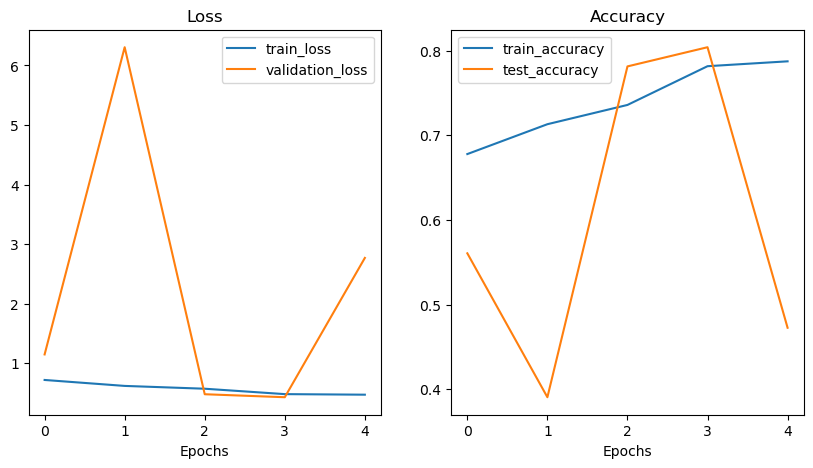

In [16]:
from utils import plot_loss_curves
plot_loss_curves(model_results)

In [17]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_1.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_1(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/16 [00:01<?, ?it/s]

In [22]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);


AttributeError: 'list' object has no attribute 'ndim'